In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from PCA_NP import pca_np

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
#read all images from the folder
def read_images(folder_images, folder_masks):
    dict_images = {}
    for filename in os.listdir(folder_images):
        img = Image.open(os.path.join(folder_images, filename))
        mask = Image.open(os.path.join(folder_masks, filename.split('.')[0] + '_segmentation.png'))
        if img is not None and mask is not None:
            dict_images[filename.split('.')[0]] = {}
            dict_images[filename.split('.')[0]]['image'] = img
            dict_images[filename.split('.')[0]]['mask'] = mask
            matrices, explained_var_scores = pca_np(np.array(img))
            dict_images[filename.split('.')[0]]['pca'] = (matrices, explained_var_scores)
    return dict_images

In [6]:
folder_images = '../../data/kvasir_new_processed/train/images'
folder_masks = '../../data/kvasir_new_processed/train/masks'

In [7]:
images_dict = read_images(folder_images, folder_masks)

In [8]:
#DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem[1]['pca'][1])
#    if i == 0:
#        break

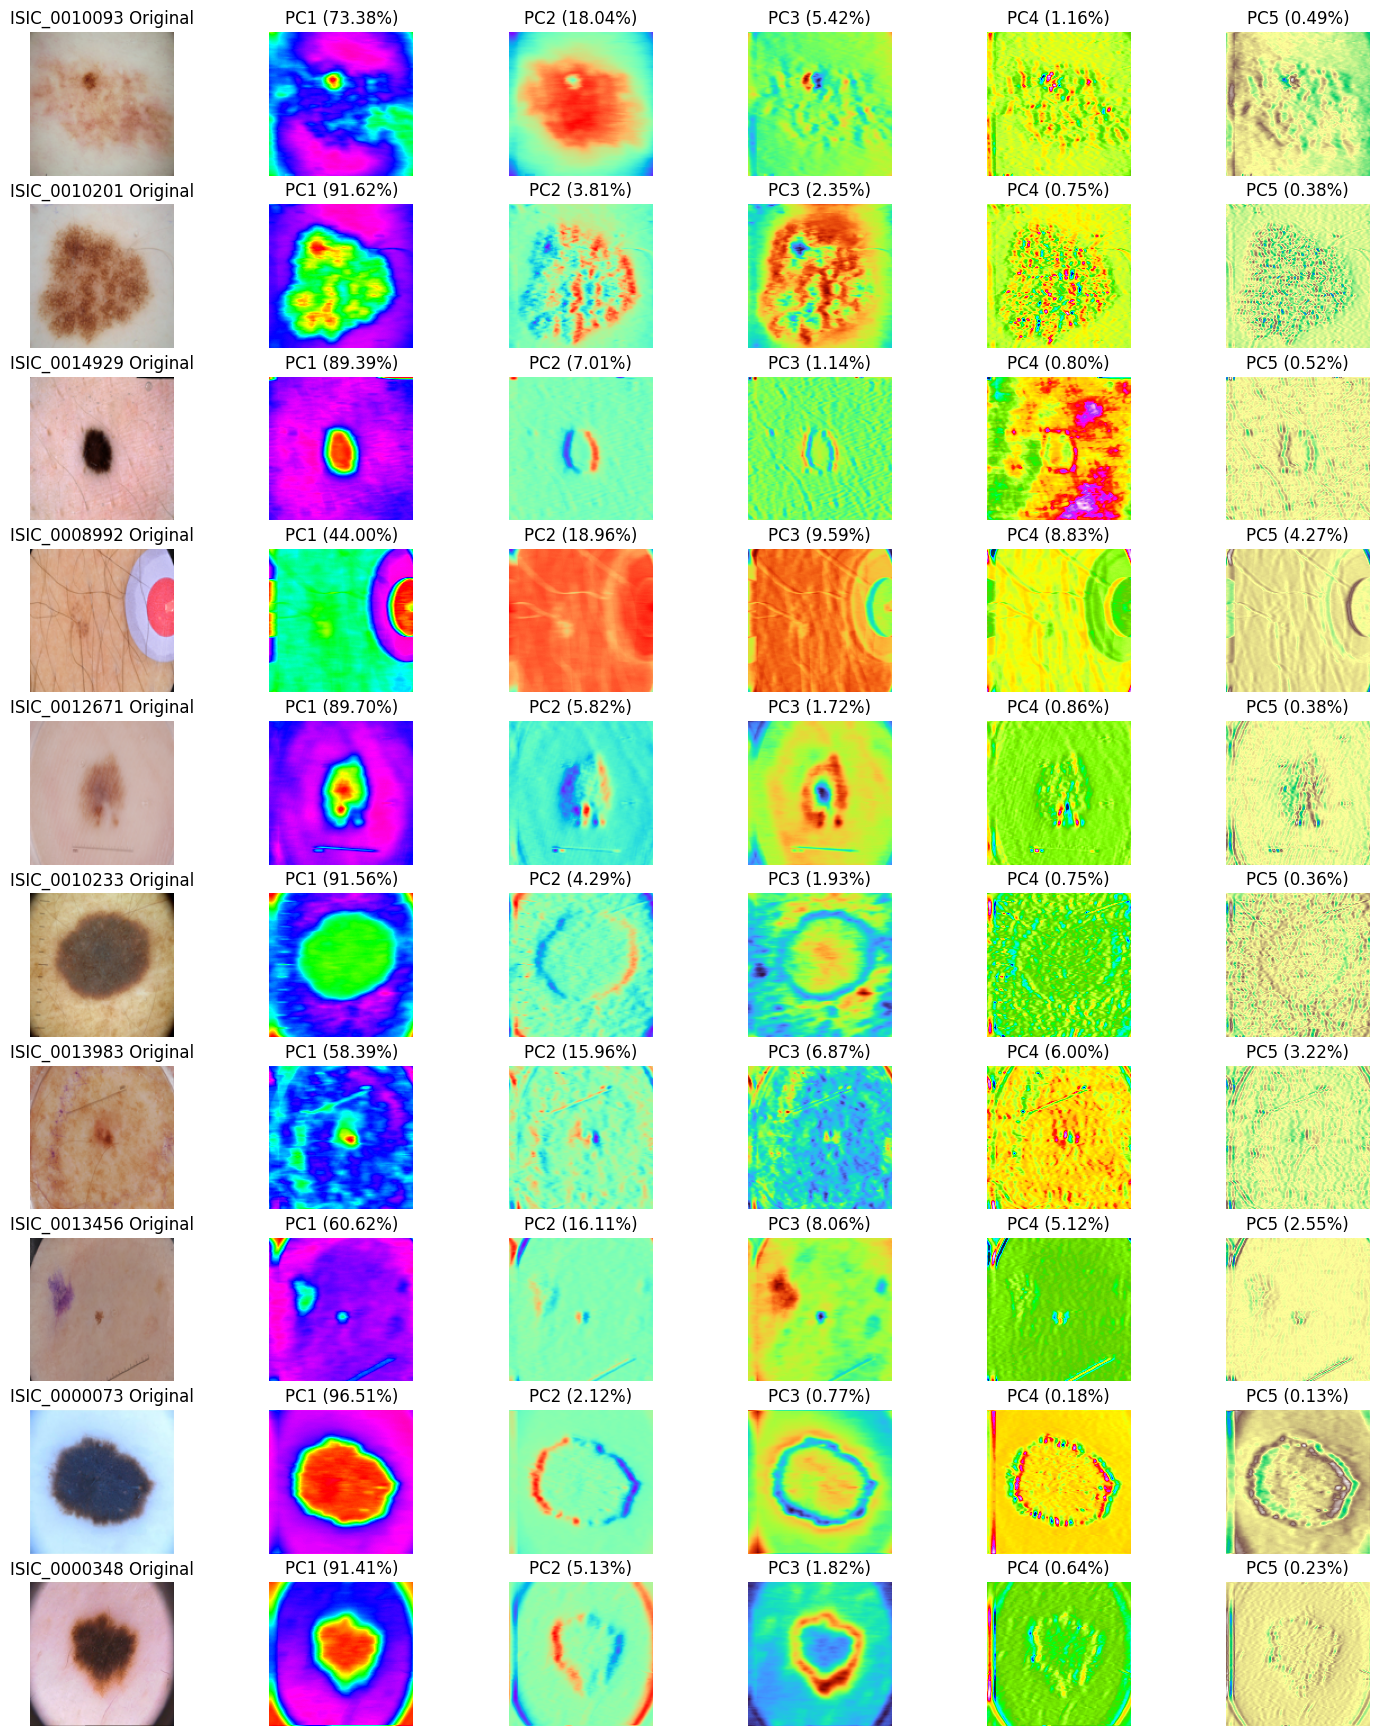

In [9]:
# plot the pca_np image
fig, ax = plt.subplots(10, 6, figsize=(18, 22))
colors = ['gist_rainbow', 'rainbow', 'turbo', 'gist_ncar', 'terrain']
for i, item in enumerate(images_dict.items()):
    if i == 10:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    for j, matrix in enumerate(item[1]['pca'][0]):
        ax[i, j+1].imshow(matrix, cmap=colors[j])
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'PC{j+1} ({item[1]['pca'][1][j]:.2f}%)')

In [10]:
# function to calculate dice score given two numpy masks
def dice_score(mask1, mask2):
    mask1 = np.asarray(mask1).astype(bool)
    mask2 = np.asarray(mask2).astype(bool)
    intersection = np.sum(mask1 & mask2)
    dice = 2 * intersection / (np.sum(mask1) + np.sum(mask2))
    return dice

# function to calculate the IoU score given two numpy masks
def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return intersection.sum() / union.sum()

In [11]:
for i, item in enumerate(images_dict.items()):
    predictor.set_image(np.array(item[1]['image']))
    images_dict[item[0]]['predicted_masks_pca'] = []
    images_dict[item[0]]['dice_scores_predicted_masks_pca'] = []
    images_dict[item[0]]['iou_scores_predicted_masks_pca'] = []
    #if i == 5:
    #    break
    for j, matrix in enumerate(item[1]['pca'][0]):
            
            # apply convolutional filter to the matrix using cv2
            kernel = np.ones((5,5),np.float32)/25
            matrix = cv2.filter2D(matrix,-1,kernel)
            ## binarize the matrix
            mean_value = np.mean(matrix)
            std_value = np.std(matrix)
            matrix[matrix < mean_value + 2*std_value] = 0
            matrix[matrix > mean_value + 2*std_value ] = 1

            matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
            matrix_sam_fixed[0] = cv2.resize(matrix, (256, 256), interpolation=cv2.INTER_LINEAR)
            matrix_sam_fixed = 1 - matrix_sam_fixed

            #fig, ax = plt.subplots(1, 2)
            #ax[0].imshow(item[1]['image'])
            #ax[0].axis('off')
            #ax[0].set_title(item[0] + ' Original')
            #ax[1].imshow(matrix_sam_fixed[0], cmap='gray')
            #ax[1].axis('off')
            #ax[1].set_title(f'PC{j+1} ({item[1]['pca'][1][j]:.2f}%)')
            #plt.show()

            masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = 1 - masks[1] # get the second mask
            #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
            mask = np.array(mask).astype(np.float32)
            images_dict[item[0]]['predicted_masks_pca'].append(mask)
            # calculate dice and iou scores
            dice = dice_score(np.array(item[1]['mask']), mask)
            iou = iou_score(np.array(item[1]['mask']), mask)
            images_dict[item[0]]['dice_scores_predicted_masks_pca'].append(dice)
            images_dict[item[0]]['iou_scores_predicted_masks_pca'].append(iou)

In [12]:
##DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem)
#    if i == 0:
#        break

In [13]:
images_names = []
dice_scores_pca1 = []
iou_scores_pca1 = []
dice_scores_pca2 = []
iou_scores_pca2 = []
dice_scores_pca3 = []
iou_scores_pca3 = []
dice_scores_pca4 = []
iou_scores_pca4 = []
dice_scores_pca5 = []
iou_scores_pca5 = []
for i, elem in enumerate(images_dict.items()):
    images_names.append(elem[0])
    dice_scores_pca1.append(elem[1]['dice_scores_predicted_masks_pca'][0])
    iou_scores_pca1.append(elem[1]['iou_scores_predicted_masks_pca'][0])
    dice_scores_pca2.append(elem[1]['dice_scores_predicted_masks_pca'][1])
    iou_scores_pca2.append(elem[1]['iou_scores_predicted_masks_pca'][1])
    dice_scores_pca3.append(elem[1]['dice_scores_predicted_masks_pca'][2])
    iou_scores_pca3.append(elem[1]['iou_scores_predicted_masks_pca'][2])
    dice_scores_pca4.append(elem[1]['dice_scores_predicted_masks_pca'][3])
    iou_scores_pca4.append(elem[1]['iou_scores_predicted_masks_pca'][3])
    dice_scores_pca5.append(elem[1]['dice_scores_predicted_masks_pca'][4])
    iou_scores_pca5.append(elem[1]['iou_scores_predicted_masks_pca'][4])

In [14]:
df_res = pd.DataFrame({'Image': images_names, 'Dice PCA1': dice_scores_pca1, 'IoU PCA1': iou_scores_pca1, 'Dice PCA2': dice_scores_pca2, 'IoU PCA2': iou_scores_pca2, 'Dice PCA3': dice_scores_pca3, 'IoU PCA3': iou_scores_pca3, 'Dice PCA4': dice_scores_pca4, 'IoU PCA4': iou_scores_pca4, 'Dice PCA5': dice_scores_pca5, 'IoU PCA5': iou_scores_pca5})
df_res

Image  Dice PCA1  IoU PCA1  Dice PCA2  IoU PCA2  Dice PCA3  \
0     ISIC_0010093   0.774891  0.632507   0.774891  0.632507   0.774891   
1     ISIC_0010201   0.836382  0.718777   0.836760  0.719336   0.836129   
2     ISIC_0014929   0.103514  0.054582   0.103556  0.054605   0.103508   
3     ISIC_0008992   0.009667  0.004857   0.012140  0.006107   0.012613   
4     ISIC_0012671   0.232459  0.131515   0.232408  0.131483   0.232420   
...            ...        ...       ...        ...       ...        ...   
1995  ISIC_0010498   0.417846  0.264099   0.417846  0.264099   0.417846   
1996  ISIC_0010479   0.966637  0.935428   0.966637  0.935428   0.966646   
1997  ISIC_0013783   0.524154  0.355155   0.524106  0.355111   0.524226   
1998  ISIC_0000364   0.637729  0.468137   0.638367  0.468825   0.637729   
1999  ISIC_0012828   0.337915  0.203308   0.337915  0.203308   0.337915   

      IoU PCA3  Dice PCA4  IoU PCA4  Dice PCA5  IoU PCA5  
0     0.632507   0.774891  0.632507   0.774891  0.632507  
1     0.718403   0.837423  0.720317   0.838187  0.721447  
2     0.054579   0.103508  0.054579   0.103508  0.054579  
3     0.006347   0.003996  0.002002   0.009498  0.004772  
4     0.131491   0.315168  0.187062   0.232408  0.131483  
...        ...        ...       ...        ...       ...  
1995  0.264099   0.417846  0.264099   0.417846  0.264099  
1996  0.935445   0.966833  0.935795   0.966588  0.935337  
1997  0.355221   0.524082  0.355089   0.524322  0.355309  
1998  0.468137   0.637756  0.468166   0.637836  0.468252  
1999  0.203308   0.337915  0.203308   0.337915  0.203308  

[2000 rows x 11 columns]

In [15]:
df_res.describe()

Dice PCA1     IoU PCA1    Dice PCA2     IoU PCA2    Dice PCA3  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.354540     0.256042     0.353214     0.254021     0.355695   
std       0.274776     0.246811     0.271544     0.243566     0.272431   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.115999     0.061570     0.118885     0.063199     0.120496   
50%       0.287011     0.167550     0.289041     0.168935     0.290839   
75%       0.551949     0.381167     0.544353     0.373960     0.552394   
max       0.988524     0.977309     0.987632     0.975566     0.988425   

          IoU PCA3    Dice PCA4     IoU PCA4    Dice PCA5     IoU PCA5  
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  
mean      0.256154     0.355105     0.255651     0.356772     0.256719  
std       0.244240     0.272259     0.244050     0.271376     0.243586  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.064110     0.118977     0.063251     0.121056     0.064428  
50%       0.170165     0.287048     0.167575     0.291396     0.170546  
75%       0.381592     0.552237     0.381441     0.553411     0.382563  
max       0.977114     0.988425     0.977114     0.988427     0.977119

In [20]:
df_res.to_csv('pca_nb_results.csv', index=False)

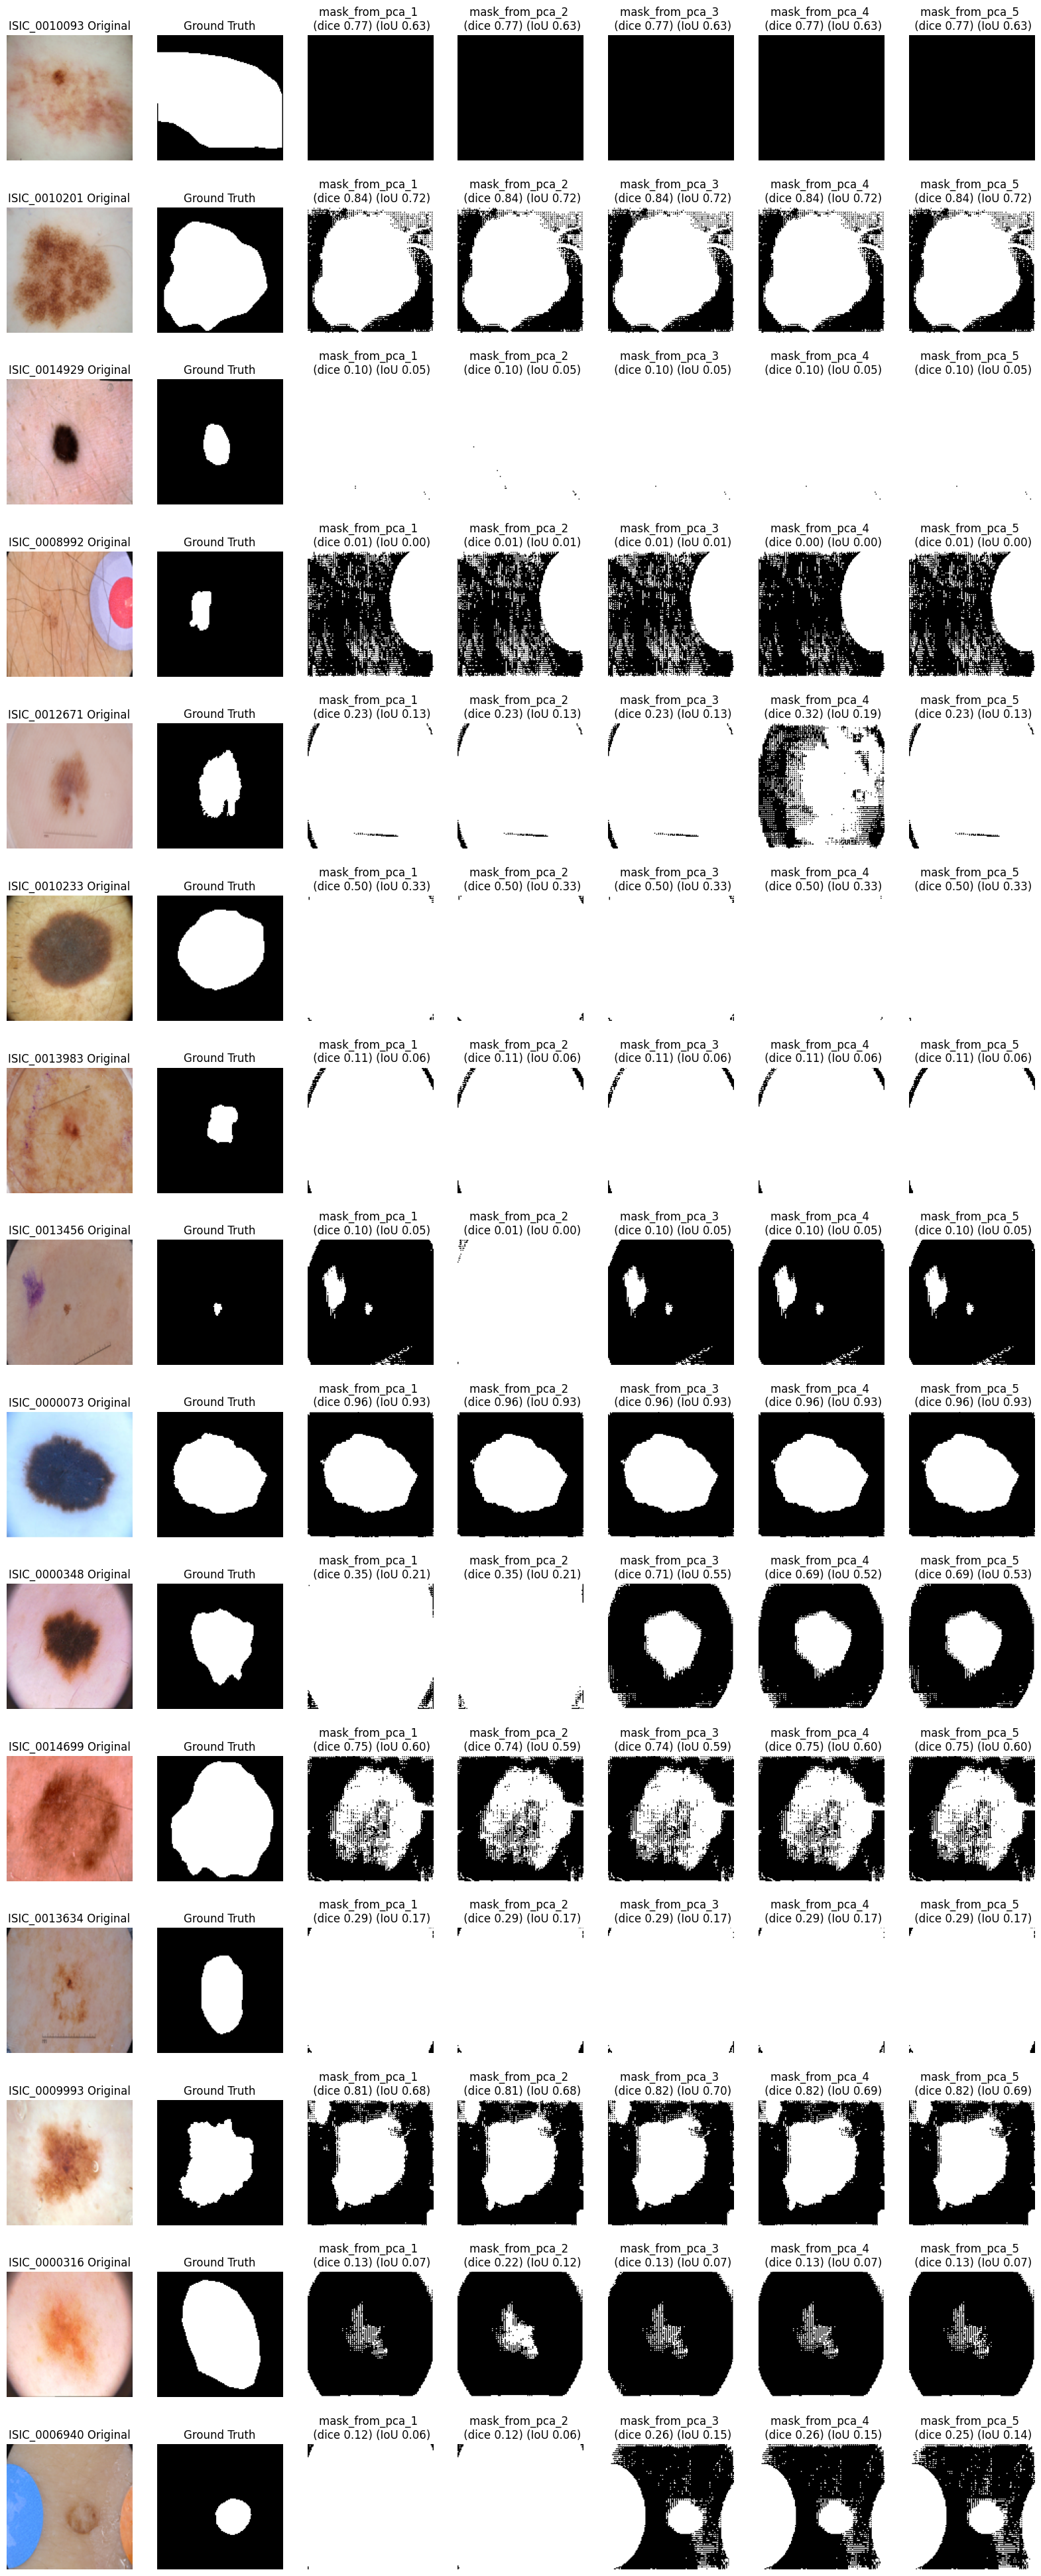

In [16]:
# plot for the first 15 images the mask for each pca component (input)
fig, ax = plt.subplots(15, 7, figsize=(20, 50))
for i, item in enumerate(images_dict.items()):
    if i == 15:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    ax[i, 1].imshow(item[1]['mask'], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Ground Truth')
    for j, matrix in enumerate(item[1]['predicted_masks_pca']):
        ax[i, j+2].imshow(matrix, cmap='gray')
        ax[i, j+2].axis('off')
        ax[i, j+2].set_title(f'mask_from_pca_{j+1} \n (dice {item[1]['dice_scores_predicted_masks_pca'][j]:.2f}) (IoU {item[1]['iou_scores_predicted_masks_pca'][j]:.2f})')

In [17]:
#            # Flatten the matrix to work with probabilities
#            flattened_matrix = matrix.flatten()
#            # Normalize the pixel values to create probabilities
#            probabilities_foreground = flattened_matrix / np.sum(flattened_matrix)
#            # Get the indices of 10 randomly selected points, with higher probabilities for larger values
#            selected_indices_foreground = np.random.choice(len(flattened_matrix), size=n_points_div2, replace=False, p=probabilities_foreground)
#            # Convert the flattened indices back to 2D coordinates
#            selected_points_foreground = np.array(np.unravel_index(selected_indices_foreground, matrix.shape)).T

In [18]:
#            inverted_values = 1.0 - flattened_matrix
#            probabilities_background = inverted_values / np.sum(inverted_values)
#            selected_indices_background = np.random.choice(len(inverted_values), size=n_points_div2, replace=False, p=probabilities_background)
#            selected_points_background = np.array(np.unravel_index(selected_indices_background, matrix.shape)).T

In [19]:
#            mean_value = np.mean(matrix)
#            matrix[matrix < mean_value] = 0
#            matrix[matrix > mean_value] = 1